# Mapping between Seismic Stations and Boreholes

This notebook finds an estimate of sedimentary thickness at each seismic station using the boreholes in the station's vicinity.

In [1]:
import geopandas as gpd
import rf
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LinearSegmentedColormap, to_rgb
from shapely import Point
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from copy import copy
from scipy import stats
import pygmt
import geodatasets
from shapely import Polygon

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException, NoSuchElementException

from utils import get_australian_sedimentary_basins, get_geological_timeline, australia_basemap

## 1. Australian Boreholes

Looking at the data from the [**Australian Borehole Stratigraphic Unit Compilation**](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/147641) 2023 v1.0.
Download as save the data in the directory `aussedthick/data/ABSUC`.

In [2]:
absuc = pd.read_csv(os.path.join("..", "data", "ABSUC", "ABSUC_v1_BASE.txt"))  # preferred stratigraphic picks for the base of each unit
absuc.set_index("GA_GUID", inplace=True)
# remove entries with NaNs in the seemingly relevant depth measurements
absuc.dropna(
    axis=0,
    subset=("TD_MD_M", "TOP_MD_M", "BASE_MD_M", "TOP_AHD_M", "BASE_AHD_M", "GA_ASUD_NO"),
    inplace=True,
)

# remove some irrelevant columns
absuc.drop(
    labels=[
        "OBJECTID",
        "GA_ENO",
        "UWI",
        "GL_AHD_M",
        "WD_AHD_M",
        "SRTM_HE_AHD_M",
        "DATUM_ELEVATION_AHD_M",
        "GA_HYDROSTRAT",
        "TAG",
        "Z_M_SRTM",
        "COMMENT",
    ],
    axis=1,
    inplace=True
)

# create geometry
absuc["geometry"] = absuc.apply(lambda x: Point(x.GDA94_LONGITUDE, x.GDA94_LATITUDE), axis=1)
absuc = gpd.GeoDataFrame(absuc)

/var/folders/3z/q924mq751jgf5h_73dyy3vx0gyx48k/T/ipykernel_20130/2752565667.py:1: DtypeWarning: Columns (4,28) have mixed types. Specify dtype option on import or set low_memory=False.
  absuc = pd.read_csv(os.path.join("..", "data", "ABSUC", "ABSUC_v1_BASE.txt"))  # preferred stratigraphic picks for the base of each unit


The borehole data is in a dataframe that lists all the stratigraphic units that all the boreholes pass through.  It does not tell us if these units are sedimentary.

Scrape Australian Stratigraphic Units Database to determine if a unit is sedimentary

In [3]:
class ASUDScraper:
    """
    A simple scraper, the purpose of which is to determine if a geological unit
    is in a sedimentary province
    """
    def __init__(self, timeout=60):
        self.base_url = "https://asud.ga.gov.au/search-stratigraphic-units/results/"
        self.initalise_driver(timeout)
        self.timedout_units = []

    def initalise_driver(self, timeout):
        options = Options()
        options.headless = True
        self.driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)
        self.wait = WebDriverWait(self.driver, timeout=timeout)

    def get_unit(self, asud_no):
        """
        input: asud_no - unique identifier for the Australian
        Stratigraphic Units Database
        """
        self.driver.get(f"{self.base_url}{asud_no}")
        try:
            # wait for the span that contains either a link to the Geological Province
            # or just some text if no provice is found
            span = self.wait.until(lambda driver: driver.find_element(By.XPATH, "//ga-search-stratigraphic-units-results-details/div/div/div[2]/table/tbody/tr[3]/td[2]/div/span"))
            link = span.find_element(By.XPATH, "./a")
            return link
        except TimeoutException:
            self.timedout_units.append(asud_no)
            return None
        except NoSuchElementException:
            return None
    
    def is_sedimentary(self, asud_no):
        link = self.get_unit(asud_no)
        if link is None:
            return False
        link.click()
        try:
            table = self.wait.until(lambda driver: driver.find_element(By.XPATH, "//ga-geological-province/div/div[1]/div[1]/table"))
            row = table.find_element(By.XPATH, ".//tbody/tr[last()]")
        except TimeoutException:
            self.timedout_units.append(asud_no)
            return False
        except NoSuchElementException:
            return False
        
        try:
            sedimentary = re.search("Type:\s+sedimentary", row.text)
        except UnboundLocalError: # no row found
            sedimentary = False

        return True if sedimentary else False
    
    def cleanup(self):
        self.driver.close()

Determine which stratigraphic units are sedimentary.  This will take a while the first time of running but will save the results to a file which can be loaded on repeated runs.

In [4]:
fname = os.path.join("..","data","ABSUC","sedimentary_units.txt")
if os.path.exists(fname):
    sedimentary_units = np.loadtxt(fname)
else:
    def get_sedimentary_units(units):
        scraper = ASUDScraper(timeout=20)
        sedimentary = [unit for unit in tqdm(units) if scraper.is_sedimentary(unit)]
        timedout = copy(scraper.timedout_units)
        scraper.cleanup()
        return sedimentary, timedout

    asud_nos = absuc["GA_ASUD_NO"].unique()
    asud_nos = asud_nos[~np.isnan(asud_nos)].astype(int)
    sedimentary_units, timedout = get_sedimentary_units(asud_nos)
    np.savetxt(fname, sedimentary_units)

In the borehole data, add a column saying which units are sedimentary

In [5]:
absuc["SEDIMENTARY"] = False
absuc.loc[absuc["GA_ASUD_NO"].isin(sedimentary_units),"SEDIMENTARY"] = True

Create a smaller dataframe with just the necessary borehole data.
Again this will take a while at the first run.

In [6]:
def drop_offshore(points):
    """
    Removes points that are not in mainland Australia or Tasmania

    :param points: GeoDataBase
    """
    NE = gpd.read_file(geodatasets.get_path("naturalearth land"))
    _rough = Polygon(((112, -46), (112, -8), (155, -8), (155, -46)))
    _region = NE[NE.within(_rough)]
    aus = _region[
        _region.scalerank == 0
    ]  # not sure what `scalerank` means but it works - finds continent and TAS
    return points[
        points.within(aus.iloc[0].geometry) | points.within(aus.iloc[1].geometry)
    ]
   

In [7]:
# create a smaller dataframe with just the necessary borehole data

fname = os.path.join("..", "data", "ABSUC", "boreholes.geojson")
if not os.path.exists(fname):
    boreholes = gpd.GeoDataFrame(absuc.drop_duplicates("GA_BOREHOLE_GUID"))
    boreholes.set_index("GA_BOREHOLE_GUID", inplace=True)
    boreholes = boreholes.loc[
        :, ("BOREHOLE_NAME", "GDA94_LATITUDE", "GDA94_LONGITUDE", "geometry")
    ]

    # Drop offshore boreholes
    boreholes = drop_offshore(boreholes)

    # determine borehole depth to basement
    boreholes["BASEMENT_DEPTH"] = 0
    boreholes["BOTTOM"] = False  # If True, depth picked was the last layer
    for borehole_id in tqdm(boreholes.index):
        units = absuc[absuc["GA_BOREHOLE_GUID"] == borehole_id].copy()
        units.sort_values(
            by="BASE_MD_M", axis=0, ascending=False, inplace=True
        )  # BASE_MD_M is depth so largest is bottom
        for i, (_, unit) in enumerate(units.iterrows()):
            if unit["SEDIMENTARY"]:
                boreholes.loc[unit["GA_BOREHOLE_GUID"], "BASEMENT_DEPTH"] = unit[
                    "BASE_MD_M"
                ]
                if i == 0:
                    boreholes.loc[unit["GA_BOREHOLE_GUID"], "BOTTOM"] = True
                break

    boreholes.sort_values(by="BASEMENT_DEPTH", inplace=True)
    boreholes.to_file(fname, driver="GeoJSON")
else:
    boreholes = gpd.read_file(fname)

Plot map of borehole sediment thicknesses

plot [WARNING]: Your data array row 44 contains NaNs - no resampling taken place!


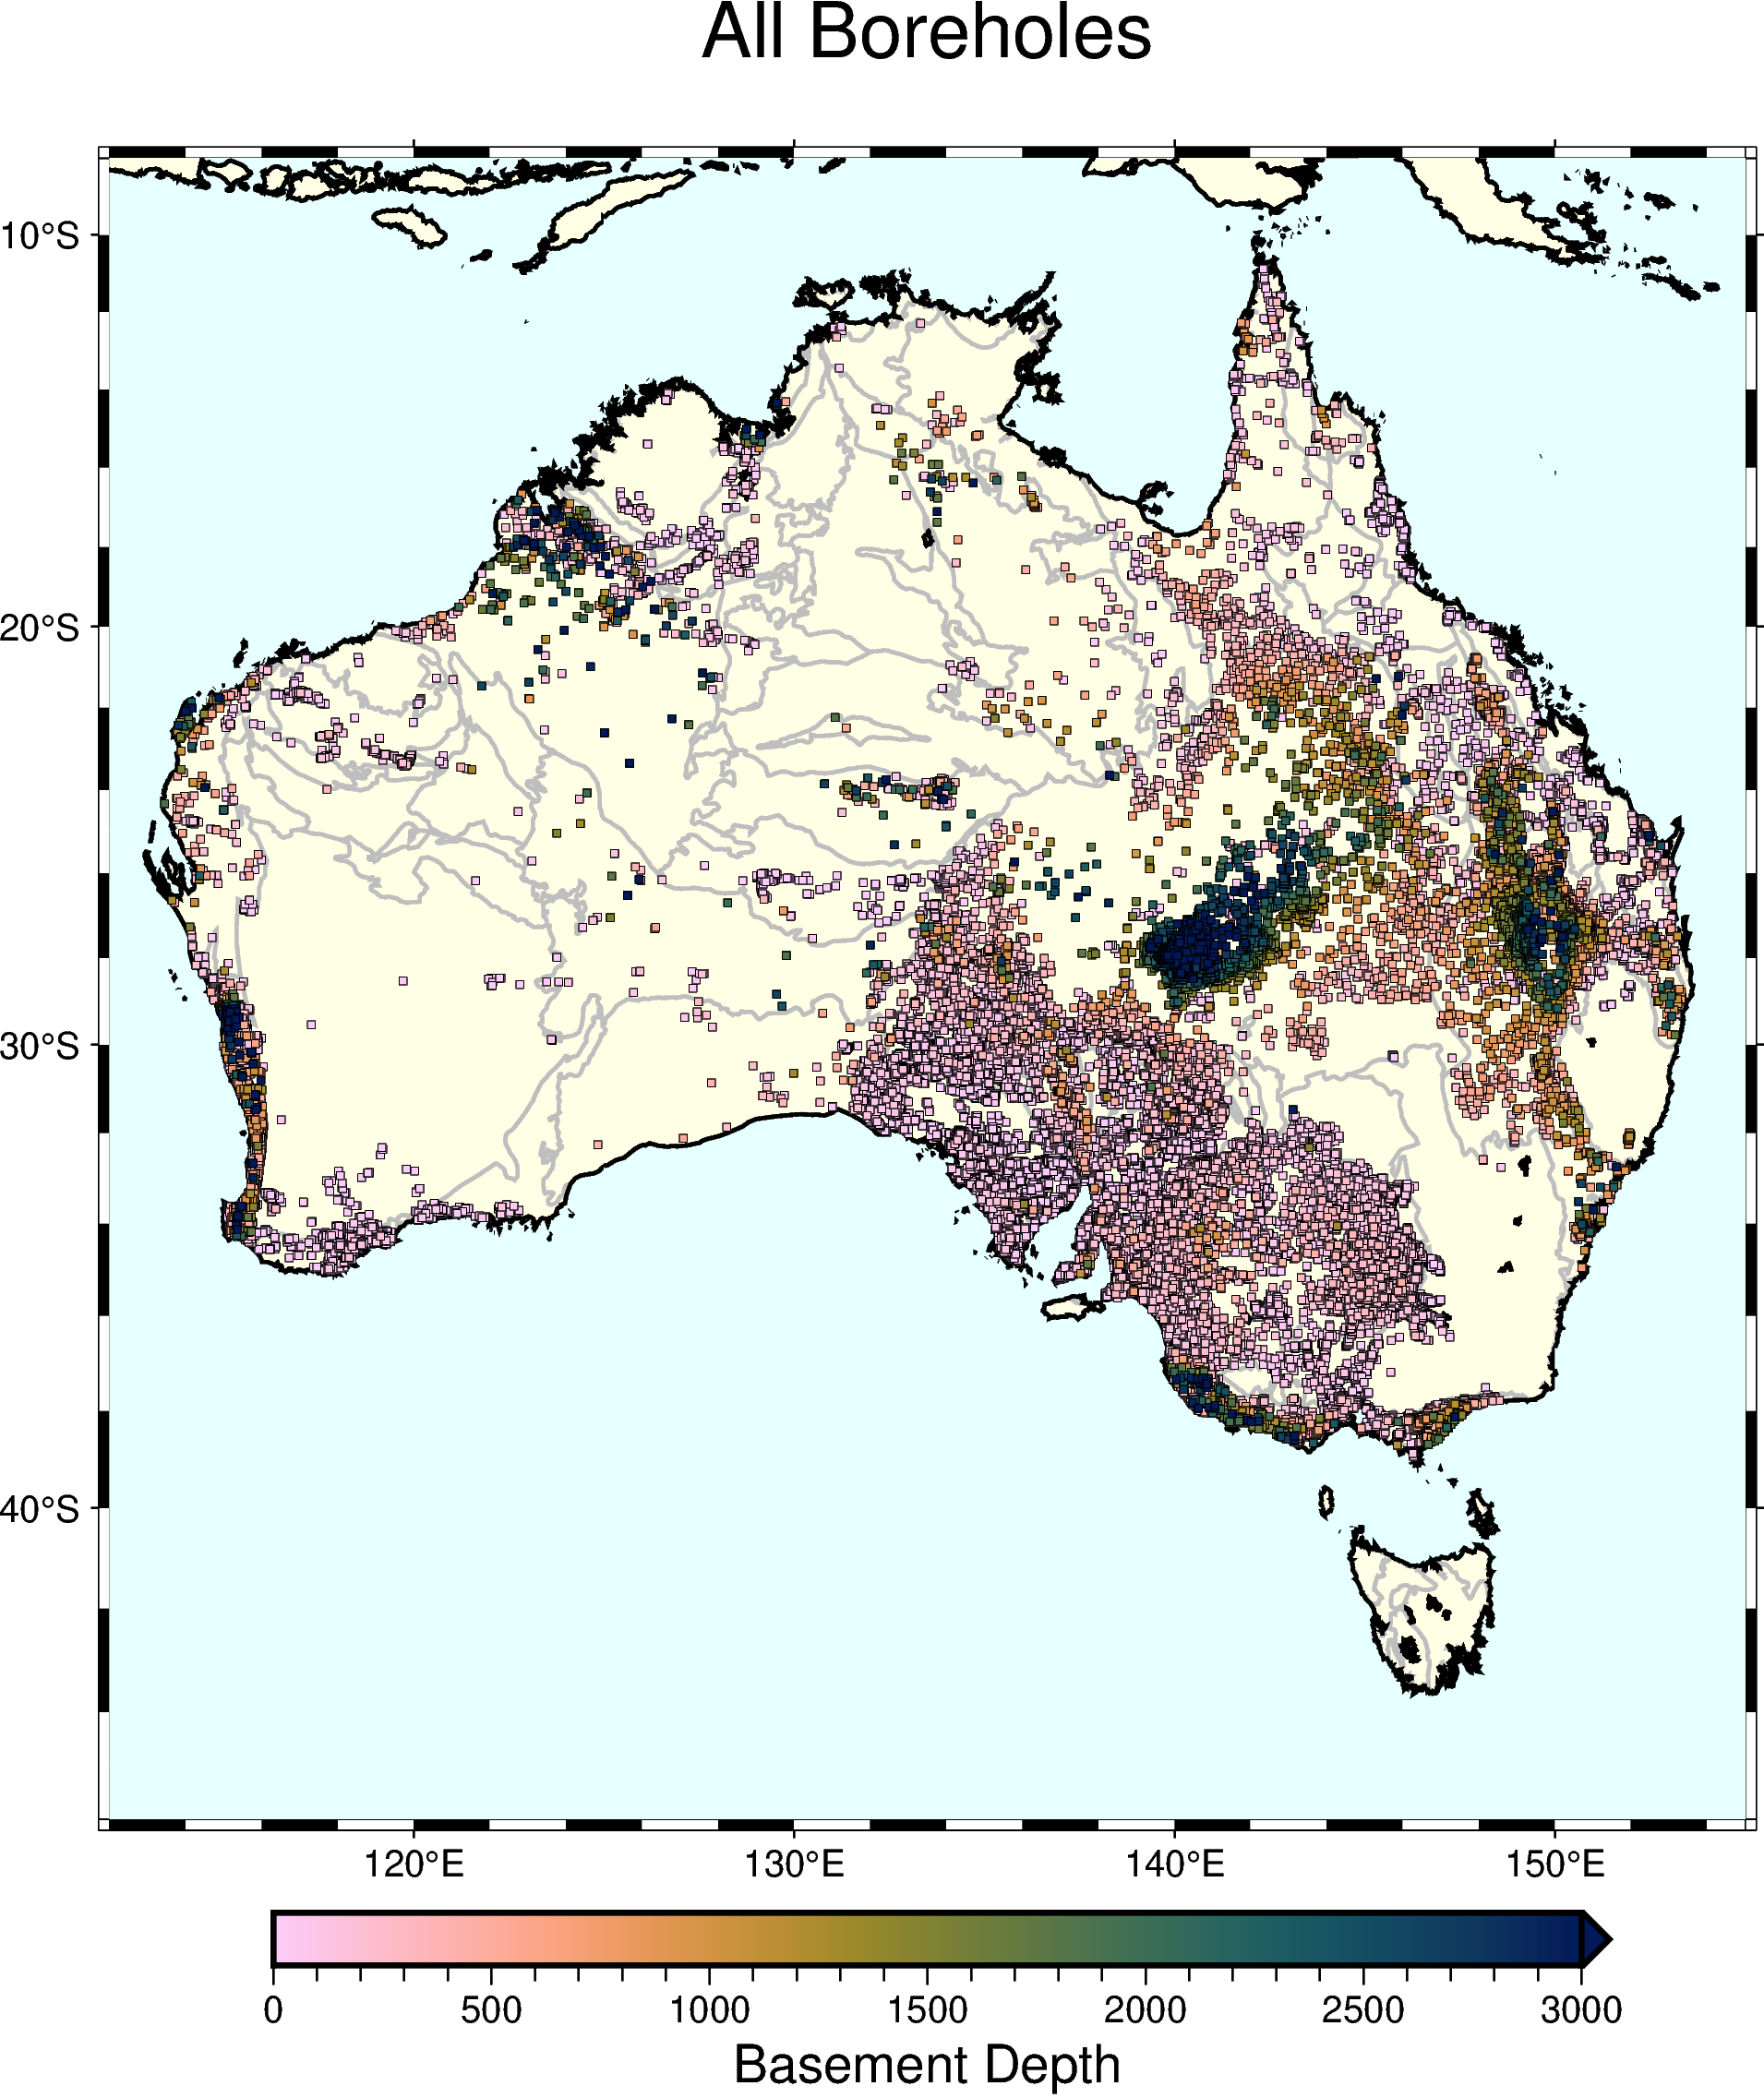

In [8]:
boreholes.sort_values("BASEMENT_DEPTH", ascending=True, inplace=True)
fig, region, projection = australia_basemap(frame=["af" , "+tAll Boreholes"])
pygmt.makecpt(
    cmap="batlow",
    series=[0, round(np.percentile(boreholes.BASEMENT_DEPTH, 99), -3)],
    reverse=True
)
x = boreholes.GDA94_LONGITUDE
y = boreholes.GDA94_LATITUDE
fig.plot(
    region=region,
    projection=projection,
    x=x,
    y=y,
    fill=boreholes.BASEMENT_DEPTH,
    cmap=True,
    style=f"sc",
    pen="0p",
    size=np.full_like(x, 0.1),
)
fig.colorbar(
    region=region,
    projection=projection,
    frame=["af+lBasement Depth"],
    position="JBC+ef",
)
fig.show()

## 2. Sedimentary Thickness at Seismic Stations from Boreholes

Load RF data

In [9]:
dataroot = os.path.join("..", "data", "processed")
run = max(
    [
        os.path.join(dataroot, d)
        for d in os.listdir(dataroot)
        if os.path.isdir(os.path.join(dataroot, d))
    ],
    key=os.path.getmtime,
)
stacks = rf.read_rf(os.path.join(run, "rfstacks.h5"), format='h5').sort(["delay","network", "station"])
autos = rf.read_rf(os.path.join(run, "autostacks.h5"), format='h5')

Make geodataframe with relevant seismic data

In [10]:
stations = []
points = []
tpsbs = []
twtts = []
for tr in stacks:
    stations.append(".".join([tr.stats.network, tr.stats.station]))
    points.append(Point(tr.stats.station_longitude, tr.stats.station_latitude))
    tpsbs.append(tr.stats.delay)

    net = tr.stats.network
    sta = tr.stats.station
    try:
        auto = autos.select(network=net, station=sta)[0]
        twtts.append(auto.stats.twtt)
    except IndexError:
        twtts.append(np.nan)

seismics = gpd.GeoDataFrame(
    data={
        "stations": stations,
        "delays": tpsbs,
        "traveltimes": twtts,
        "geometry": points,
    }
)
seismics.set_index("stations", inplace=True)

Load boreholedata

In [11]:
dataroot = os.path.join("..", "data", "ABSUC")
boreholes = gpd.read_file(os.path.join(dataroot, "boreholes.geojson"))

Investigate borehole counts within certain ranges from seismic stations

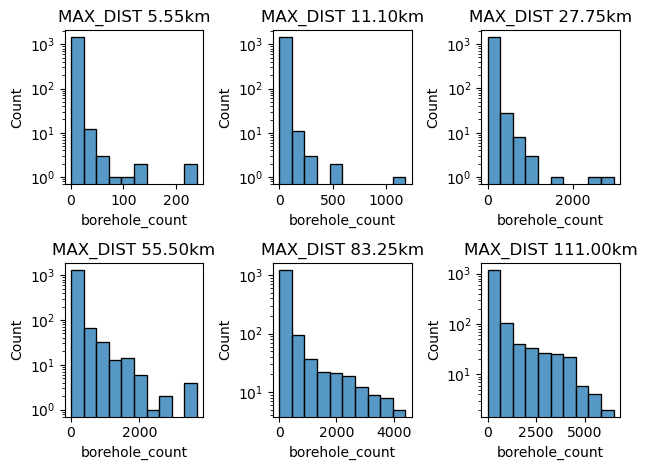

In [12]:
geo = Geodesic()  # returns distances in meters
bh_array = np.array([boreholes.geometry.x, boreholes.geometry.y]).T

fig, axs = plt.subplots(2, 3, tight_layout=True)
for ax, max_dist in zip(axs.flatten(), [0.05, 0.1, 0.25, 0.5, 0.75, 1]): # degrees
    max_dist *= 111  # km

    # define binning
    rbins = np.linspace(0, max_dist, 20)
    abins = np.linspace(0, 2 * np.pi, 36)
    R, A = np.meshgrid(rbins, abins)


    def build_hist(point):
        inv = geo.inverse([point.x, point.y], bh_array)
        inv[:, 0] /= 1000  # m -> km
        dists = inv[inv[:, 0] <= max_dist, 0]
        azs = inv[inv[:, 0] <= max_dist, 1] + 180  # range 0-360
        # calculate histogram
        hist, _, _ = np.histogram2d(dists, np.radians(azs), bins=(rbins, abins))
        return hist


    seismics["histograms"] = Parallel(n_jobs=-1)(
        delayed(build_hist)(p1) for p1 in seismics.geometry
    )
    seismics["borehole_count"] = seismics.histograms.apply(lambda x: int(x.sum()))

    sns.histplot(seismics, x="borehole_count", ax=ax, bins=10)
    ax.set_title(f"MAX_DIST {max_dist:.2f}km")
    ax.set_yscale("log")

In [13]:

def get_closest_borehole_distance(station):
    inv = geo.inverse([station.x, station.y], bh_array)
    dists = inv[:, 0] / 1000  # m -> km
    return dists.min()


seismics["closest_borehole_distance"] = np.array(
    Parallel(n_jobs=-1)(
        delayed(get_closest_borehole_distance)(p) for p in seismics.geometry
    )
)

Choose maximum distance and plot polar histograms

In [14]:
max_dist = 0.25  # degrees
max_dist *= 111 # km

# define binning
rbins = np.linspace(0, max_dist, 20)
abins = np.linspace(0, 2 * np.pi, 36)
R, A = np.meshgrid(rbins, abins)


def build_hist(point):
    inv = geo.inverse([point.x, point.y], bh_array)
    inv[:, 0] /= 1000  # m -> km
    dists = inv[inv[:, 0] <= max_dist, 0]
    azs = inv[inv[:, 0] <= max_dist, 1] + 180  # range 0-360
    # calculate histogram
    hist, _, _ = np.histogram2d(dists, np.radians(azs), bins=(rbins, abins))
    return hist


seismics["histograms"] = Parallel(n_jobs=-1)(
    delayed(build_hist)(p1) for p1 in seismics.geometry
)
seismics["borehole_count"] = seismics.histograms.apply(lambda x: int(x.sum()))


Polar histogram of borehole counts

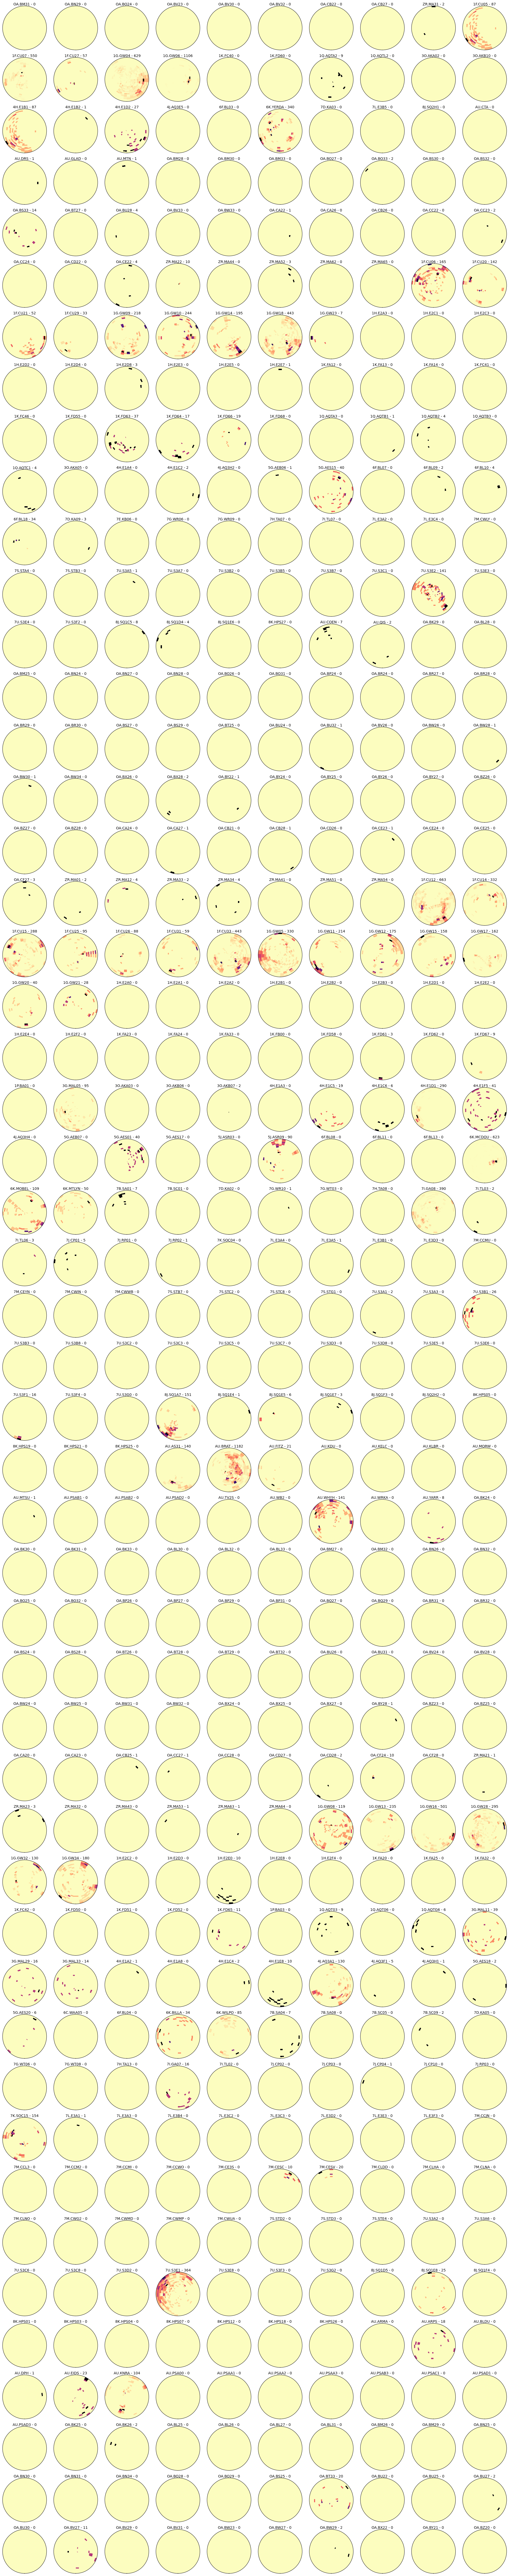

In [15]:
nrows = 50
ncols = 10
row_h = 2  # inches
col_w = 2  # inches
fig, axs = plt.subplots(
    nrows,
    ncols,
    subplot_kw=dict(projection="polar"),
    figsize=(ncols * col_w, nrows * row_h),
    tight_layout=True,
)
for ax, (i, s) in zip(axs.flatten(), seismics.iterrows()):
    # plot
    ax.grid(False)
    ax.pcolormesh(A, R, s.histograms.T, cmap="magma_r")
    ax.text(
        0.5,
        1,
        f"{i} - {int(s.borehole_count)}",
        transform=ax.transAxes,
        ha="center",
        va="bottom",
    )

    # hack to get the axes and image the right way around
    ax.set_theta_zero_location("S")
    ax.set_theta_direction(-1)
    # ax.set_xticklabels(['180°', '225°', '270°', '315°', '0°', '45°', '90°', '135°'])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

Map number of boreholes within allowed distance

/Users/u1138256/miniconda3/envs/aussedthick/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


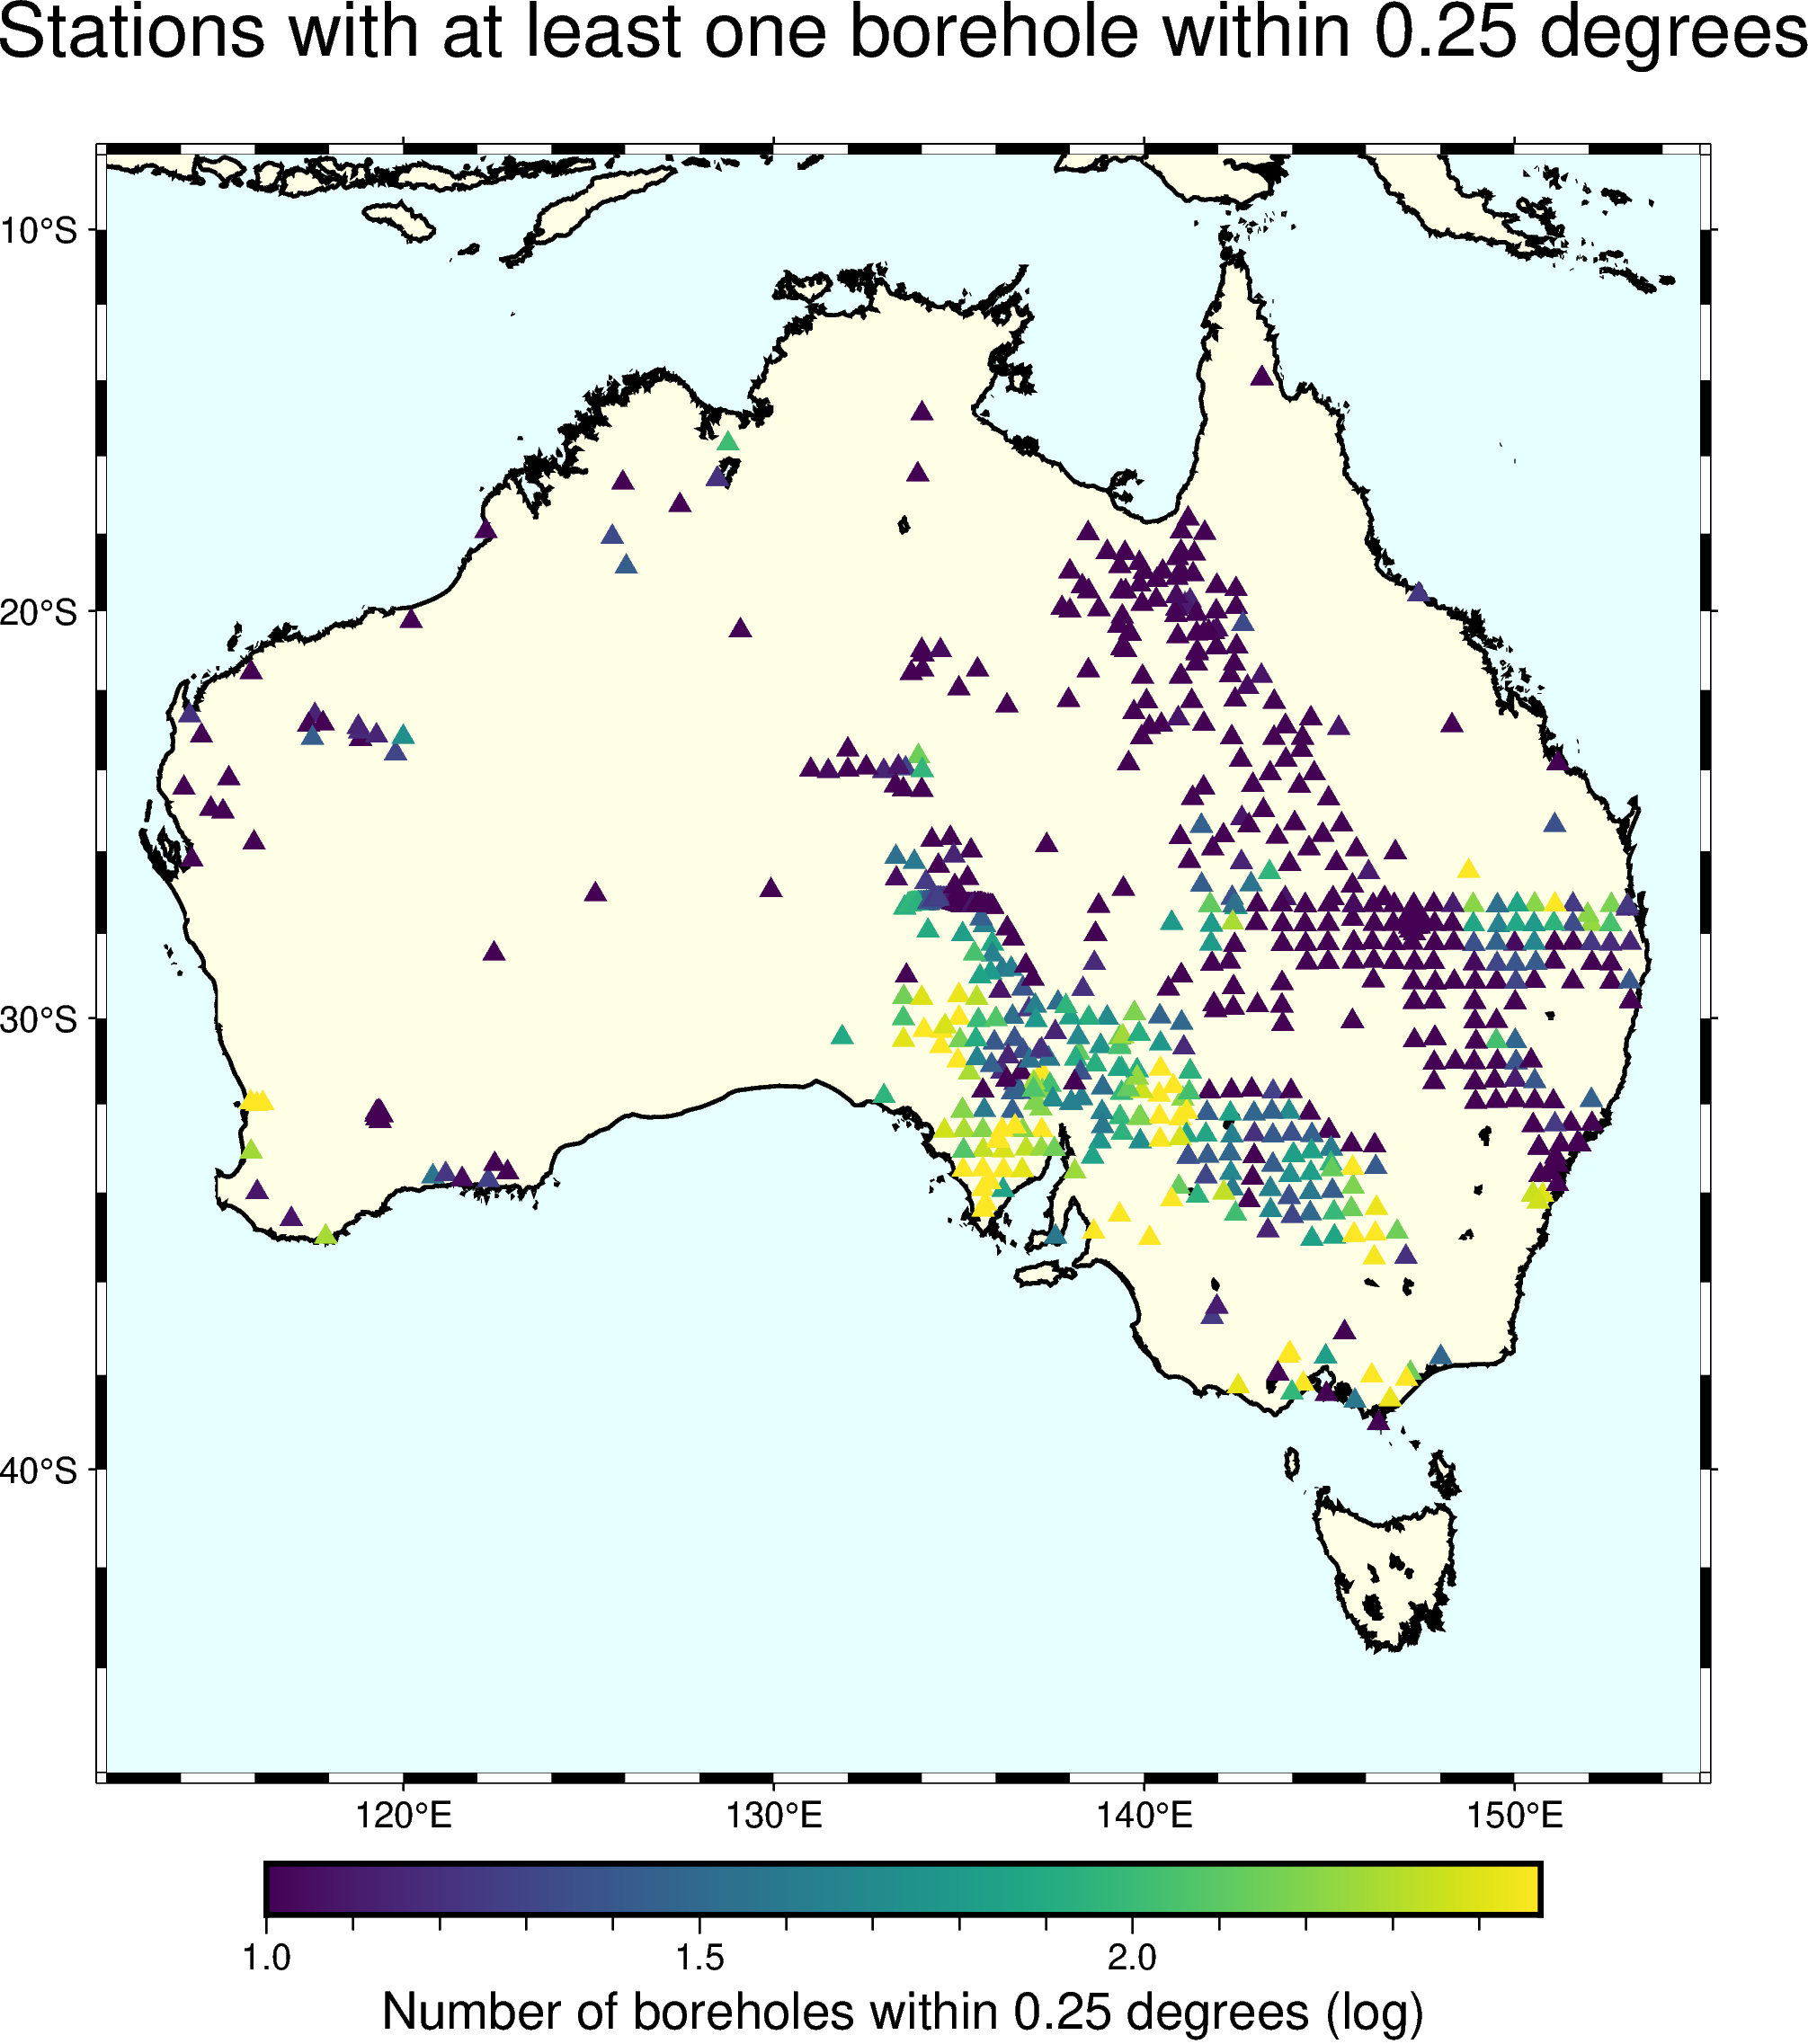

In [16]:
vmin = 1
vmax = np.log10(seismics.borehole_count).max() - 1

fig, region, projection = australia_basemap(basins=False, frame=["af", "+tStations with at least one borehole within 0.25 degrees"])
pygmt.makecpt(
    cmap="viridis",
    series=[vmin, vmax],
    background="o",
)
fig.plot(
    region=region,
    projection=projection,
    x=seismics.geometry.x[seismics.borehole_count > vmin],
    y=seismics.geometry.y[seismics.borehole_count > vmin],
    style=f"tc",
    fill=np.log10(seismics.borehole_count[seismics.borehole_count > vmin]),
    cmap=True,
    size=np.full_like(seismics.geometry.x[seismics.borehole_count > vmin], 0.25),
)
fig.colorbar(
    region=region,
    projection=projection,
    frame=['af+l"Number of boreholes within 0.25 degrees (log)"'],
    position="JBC",
)
fig.show()

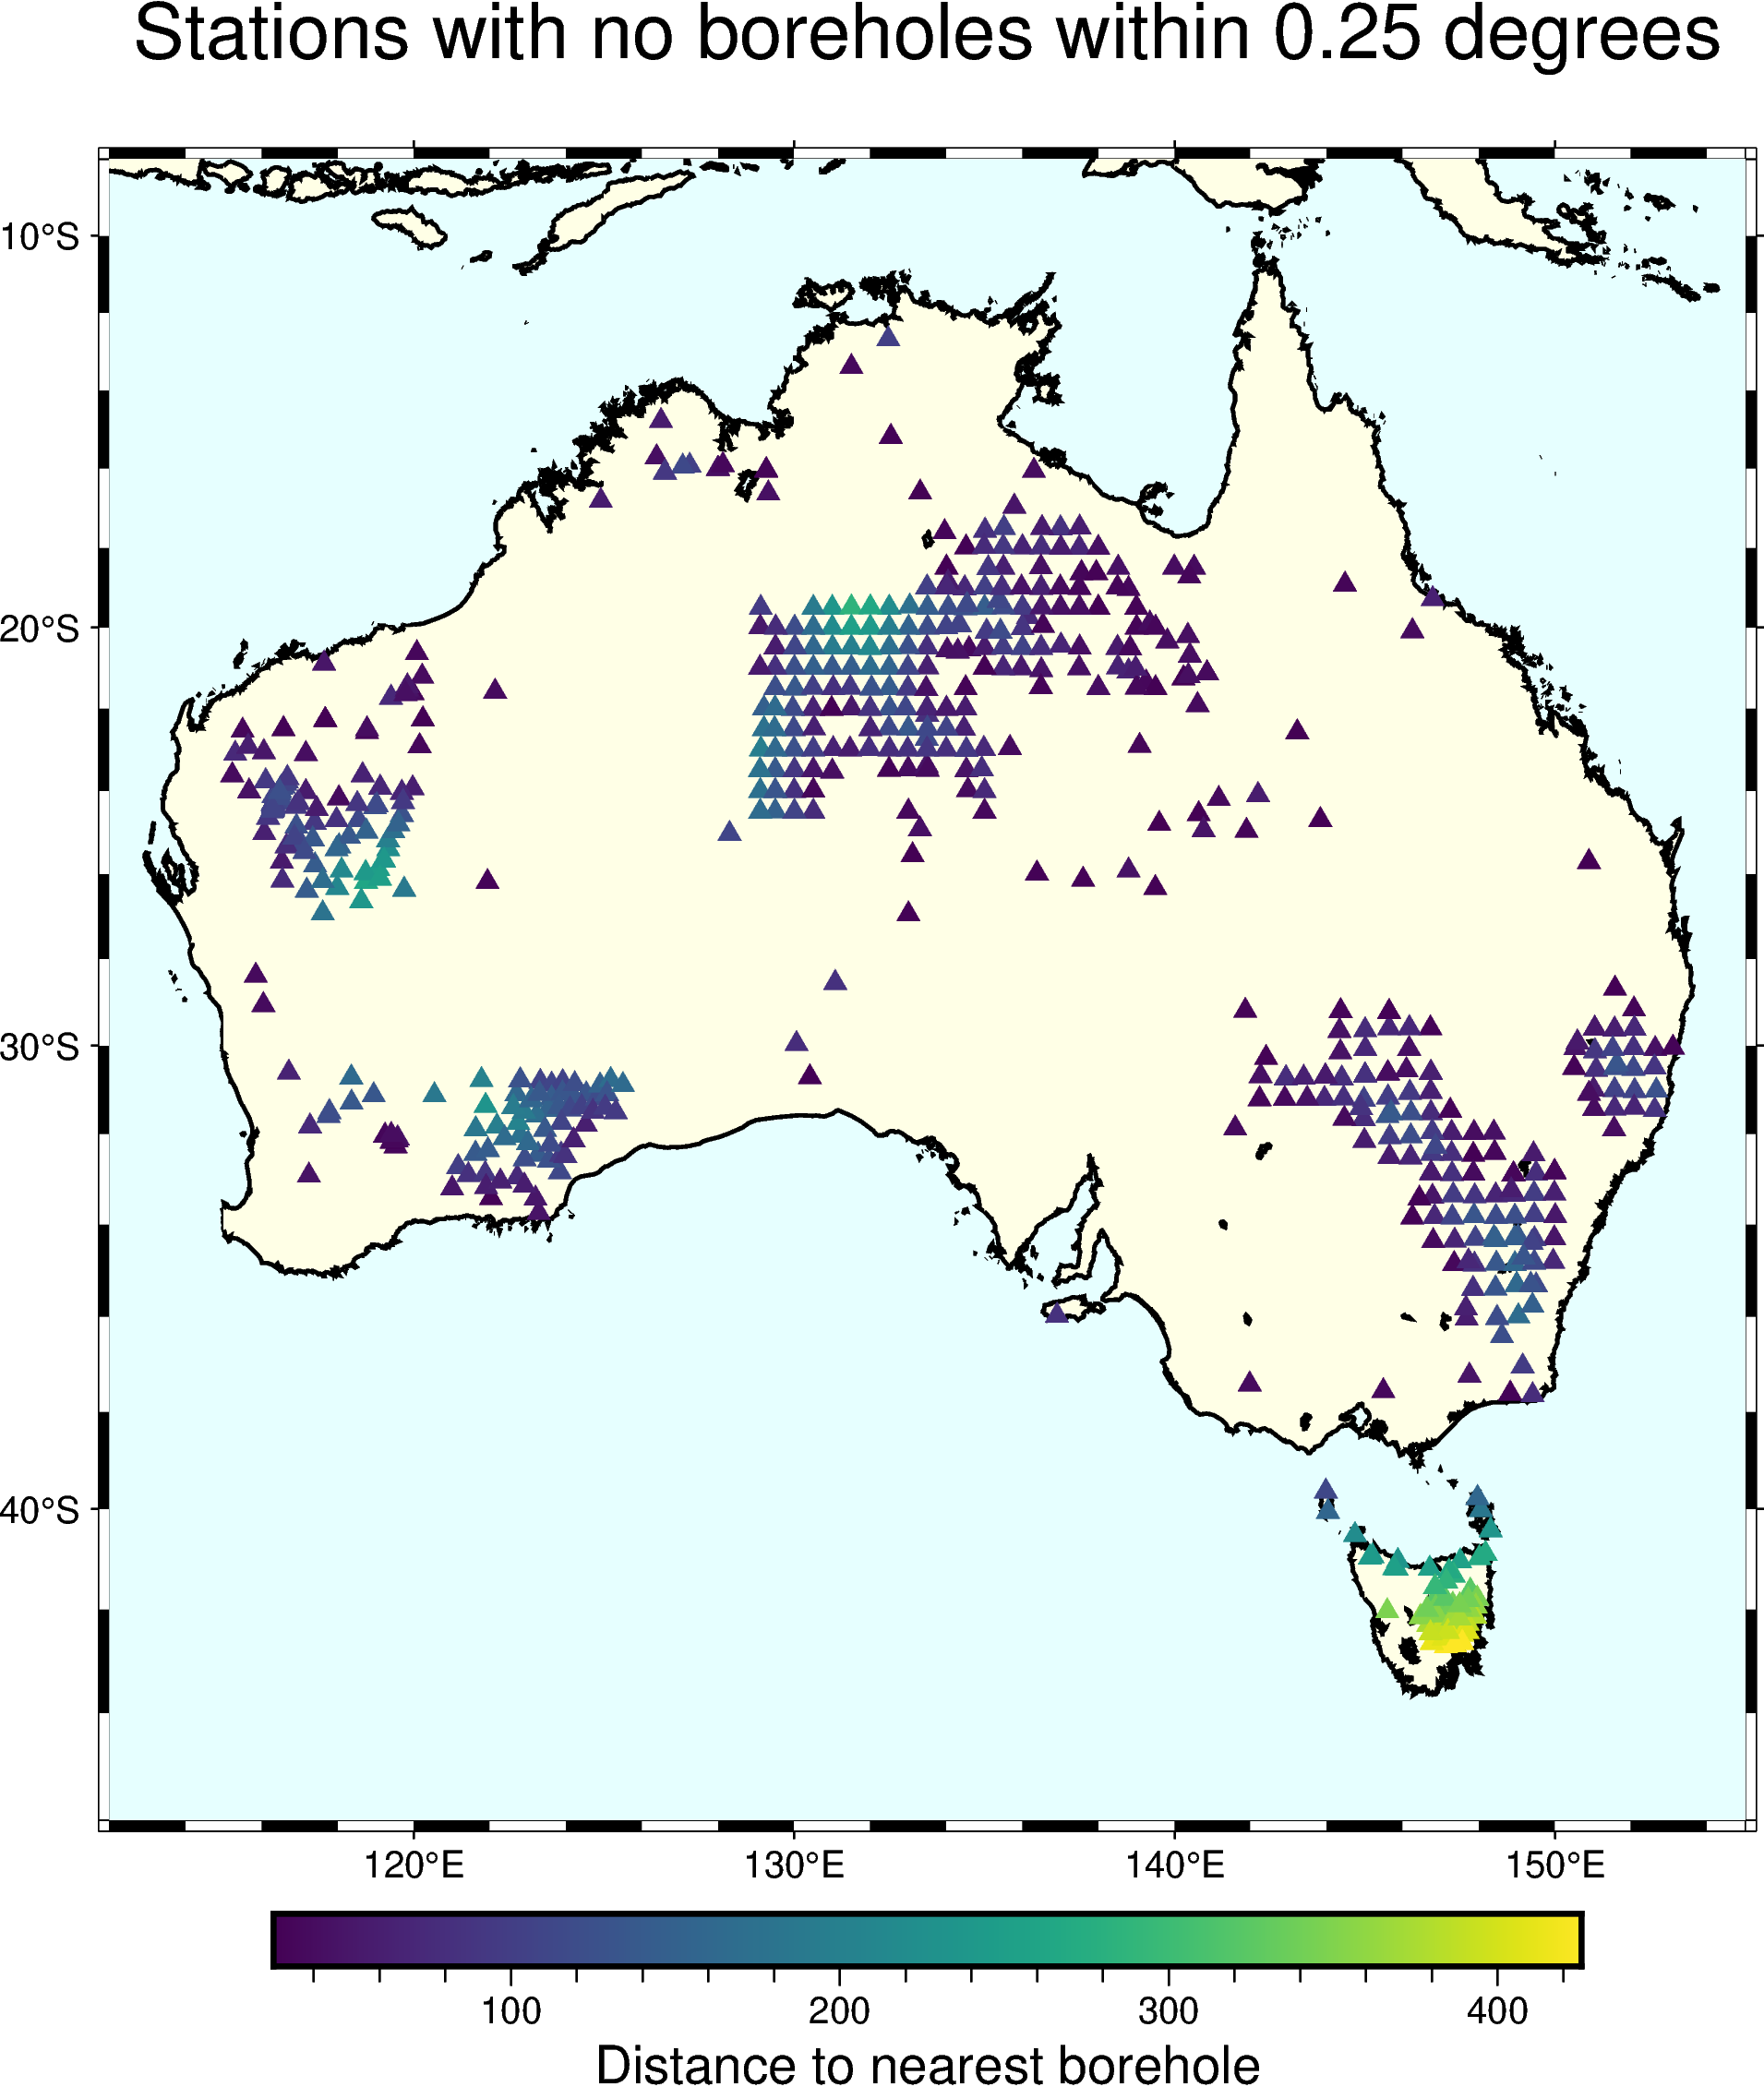

In [17]:
vmin = max_dist
vmax = seismics.closest_borehole_distance.max()
fig, region, projection = australia_basemap(basins=False, frame=["af", "+tStations with no boreholes within 0.25 degrees"])
pygmt.makecpt(
    cmap="viridis",
    series=[vmin, vmax],
    background="o",
)
fig.plot(
    region=region,
    projection=projection,
    x=seismics.geometry.x[seismics.borehole_count == 0],
    y=seismics.geometry.y[seismics.borehole_count == 0],
    style=f"tc",
    fill=seismics.closest_borehole_distance[seismics.borehole_count == 0],
    cmap=True,
    size=np.full_like(seismics.geometry.x[seismics.borehole_count == 0], 0.25),
)
fig.colorbar(
    region=region,
    projection=projection,
    frame=['af+l"Distance to nearest borehole"'],
    position="JBC",
)
fig.show()

Estimate depth at each seismic station

In [18]:
class DepthEstimators:
    def __init__(self, boreholes, max_dist=111):
        """
        boreholes - GeoDataBase with locations of boreholes with depth estimates
        max_dist - float maximum distance (km) to search for boreholes from seismic station
        """
        self.boreholes = boreholes
        self.bh_array = np.array([boreholes.geometry.x, boreholes.geometry.y]).T
        self.max_dist = max_dist

    def __call__(self, station, method=None):
        if method is None:
            method = self.max_depth
        if not isinstance(station, Point):
            raise TypeError("Input station should be of type shapely.geometry.point.Point")
        return method(station)

    def max_depth(self, station):
        return self._find_boreholes(station).BASEMENT_DEPTH.max()

    def mean_depth(self, station):
        return self._find_boreholes(station).BASEMENT_DEPTH.mean()

    def idw_mean_depth(self, station):
        bhs, dists = self._find_boreholes(station, return_dists=True)
        weights = 1 / dists
        return (bhs.BASEMENT_DEPTH * weights).sum() / weights.sum()

    def closest_depth(self, station):
        bhs, dists = self._find_boreholes(station, return_dists=True)
        return bhs.iloc[np.argmin(dists)].BASEMENT_DEPTH

    def _find_distances(self, station):
        inv = geo.inverse([station.x, station.y], self.bh_array)
        inv[:, 0] /= 1000  # m -> km
        return inv[:, 0]

    def _find_boreholes(self, station, return_dists=False):
        dists = self._find_distances(station)
        inds = np.argwhere(dists <= self.max_dist).flatten()

        if return_dists:
            if inds.size == 0:
                return self._return_empty_gdb(), np.array([np.nan])
            return self.boreholes.iloc[inds], dists[inds]

        return self._return_empty_gdb() if inds.size == 0 else self.boreholes.iloc[inds]

    def _return_empty_gdb(self):
        return gpd.GeoDataFrame(np.nan, index=[0], columns=boreholes.columns)

In [19]:
estimator = DepthEstimators(boreholes, max_dist=max_dist)


def job(method):
    return np.array(
        [estimator(station, method=method) for station in tqdm(seismics.geometry)]
    )


estimates = np.array(
    Parallel(n_jobs=4)(
        delayed(job)(method)
        for method in [
            estimator.max_depth,
            estimator.mean_depth,
            estimator.idw_mean_depth,
            estimator.closest_depth,
        ]
    )
)

100%|██████████| 1457/1457 [01:35<00:00, 15.29it/s]


In [20]:
seismics["MAX_DEPTH"] = estimates[0]
seismics["MEAN_DEPTH"] = estimates[1]
seismics["IDW_MEAN_DEPTH"] = estimates[2]
seismics["CLOSEST_DEPTH"] = estimates[3]
depth_estimates = seismics[
    ["geometry", "MAX_DEPTH", "MEAN_DEPTH", "IDW_MEAN_DEPTH", "CLOSEST_DEPTH"]
]

Map the depth estimates


plot [WARNING]: Your data array row 44 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 44 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 44 contains NaNs - no resampling taken place!
plot [WARNING]: Your data array row 44 contains NaNs - no resampling taken place!


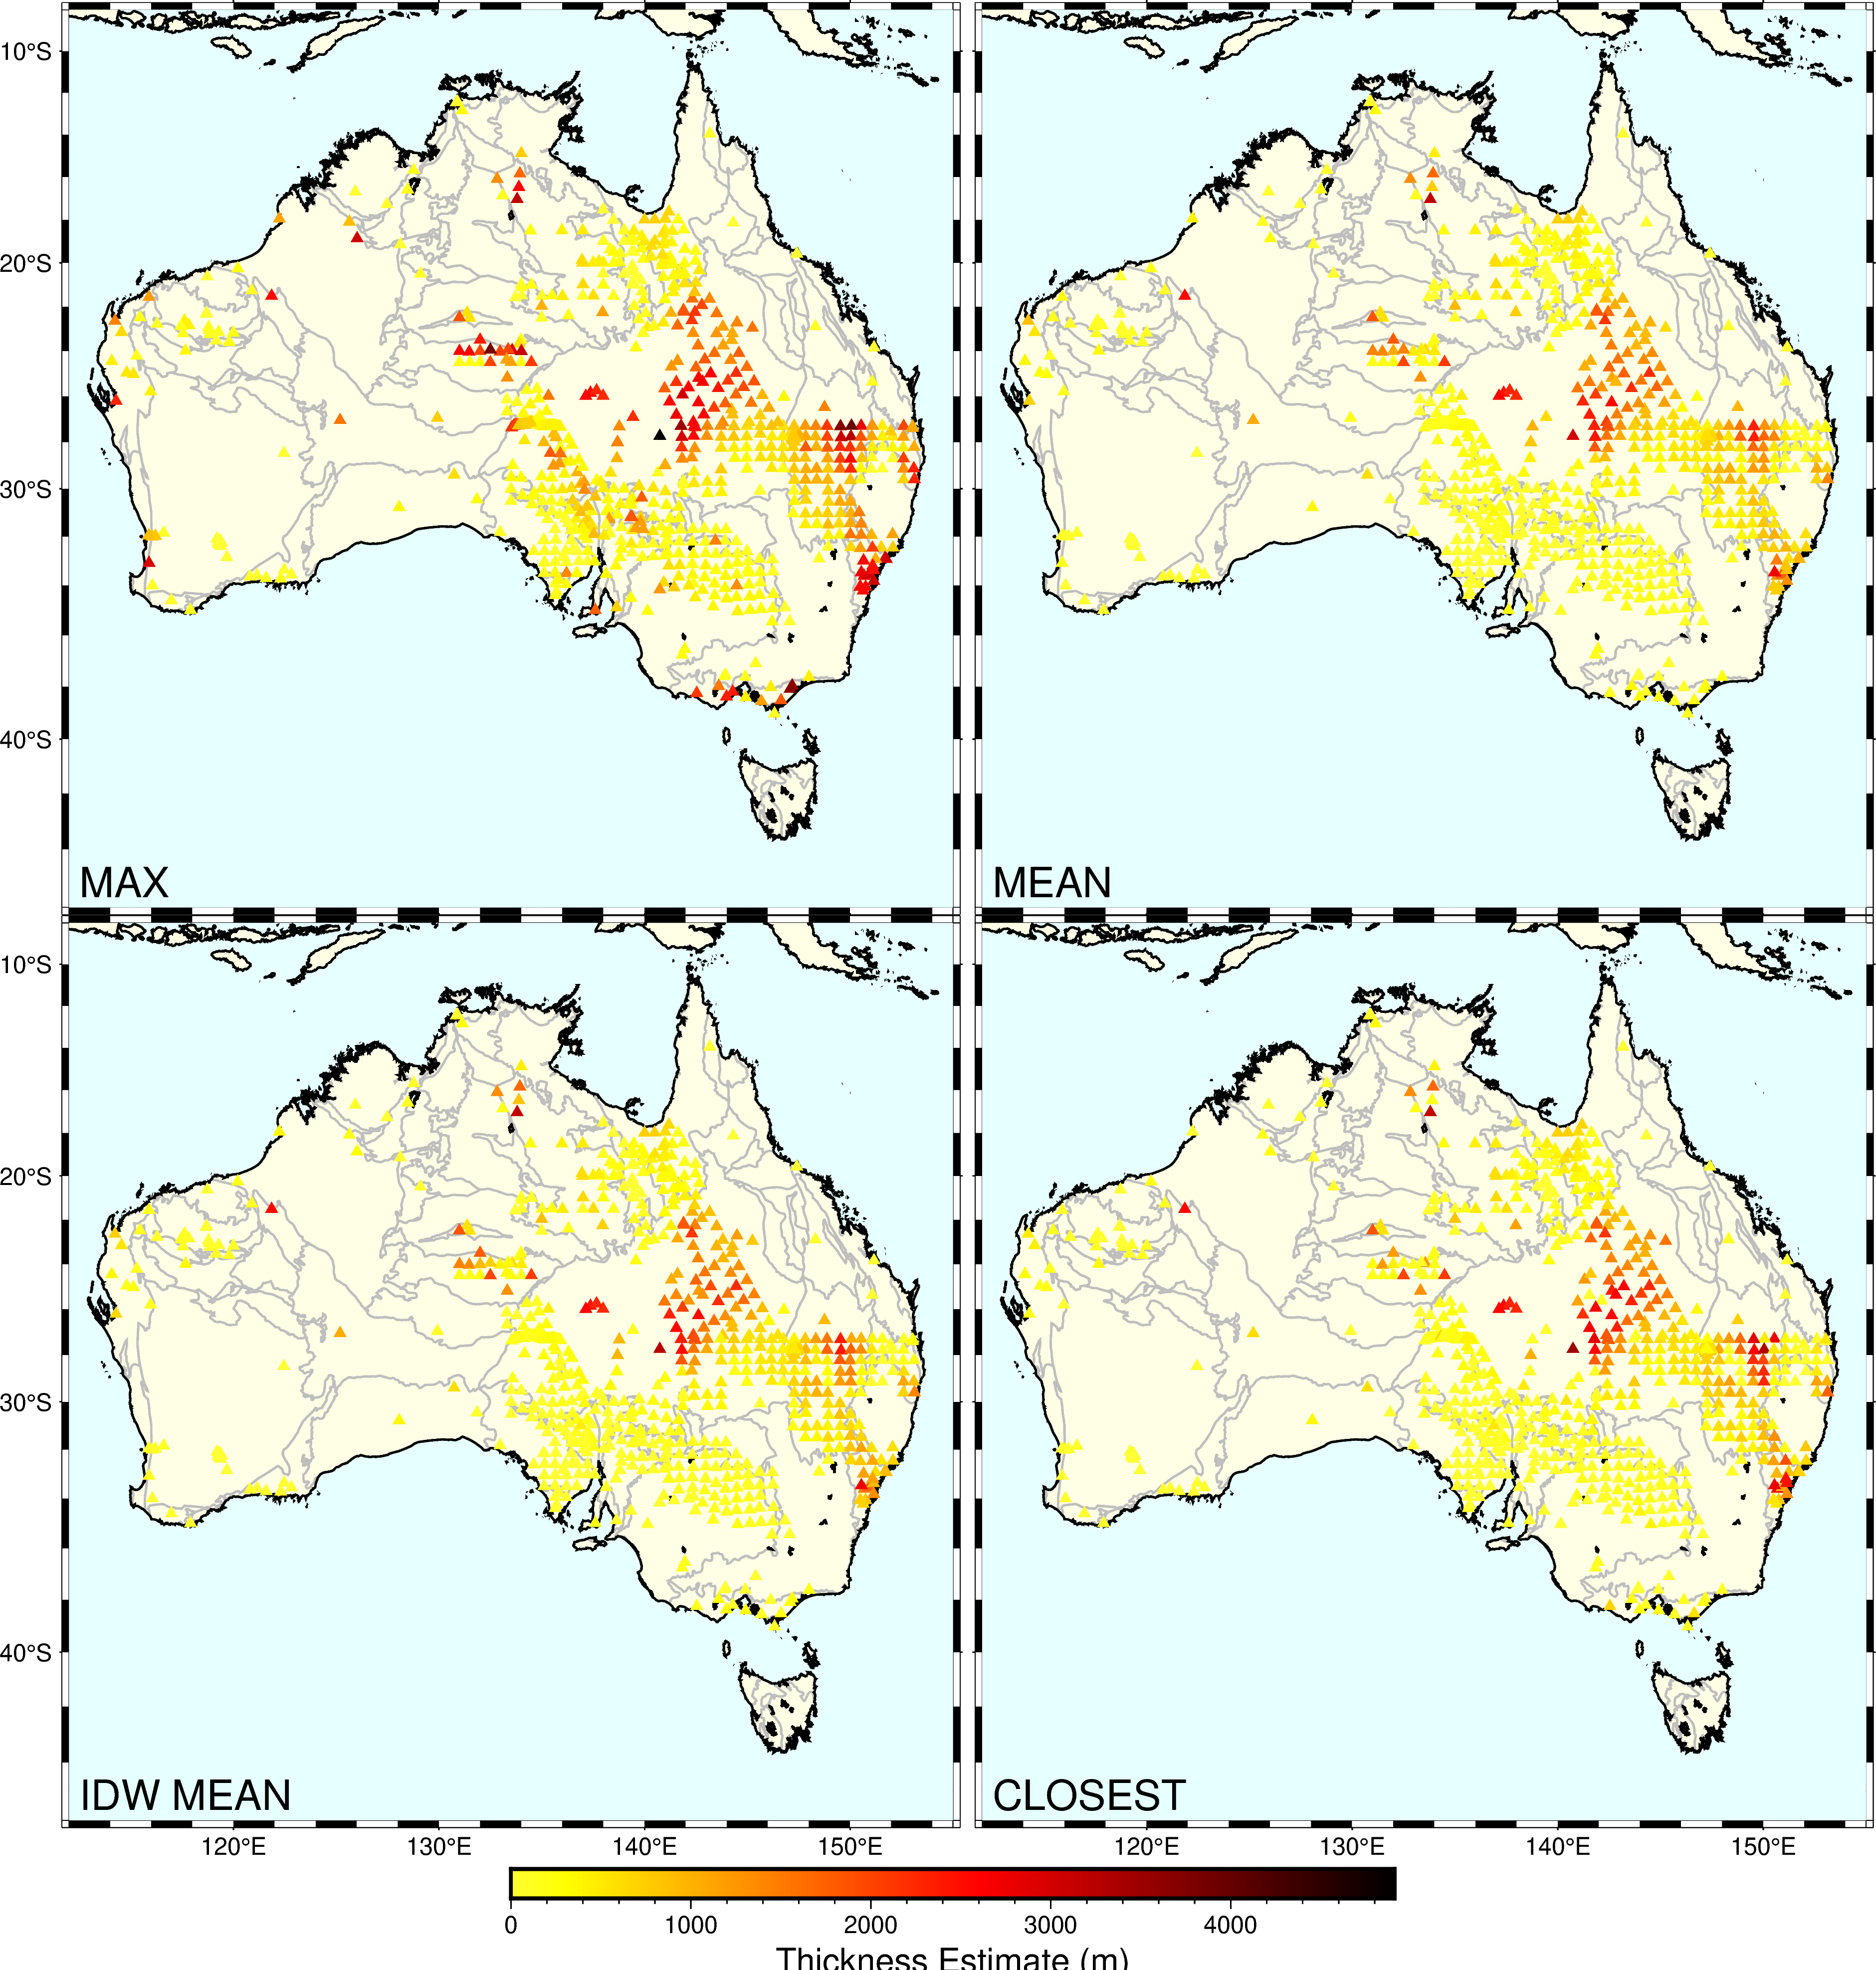

In [21]:
fig = pygmt.Figure()
vmin = (depth_estimates.loc[:, depth_estimates.columns != "geometry"].min()).min()
vmax = (depth_estimates.loc[:, depth_estimates.columns != "geometry"].max()).max()
pygmt.makecpt(cmap="hot", truncate=[0, 0.8], series=[vmin, vmax, 1],background="o", reverse=True)

with fig.subplot(nrows=2, ncols=2, figsize=("30c", "30c")):
    for i in range(2):
        for j in range(2):
            index = i * 2 + j
            depth = depth_estimates.loc[:, depth_estimates.columns != "geometry"].columns[index]
            if index == 0:
                _frame = ["Wsne"]
            elif index == 1:
                _frame = ["wsne"]
            elif index == 2:
                _frame = ["WSne"]
            elif index == 3:
                _frame = ["wSne"]
            with fig.set_panel(panel=index):
                _, _reg, _proj = australia_basemap(fig=fig, frame=_frame + ["xaf", "yaf"])
                fig.text(text=" ".join(depth.split("_")[:-1]), position="BL", font="20p", offset="5p", region=_reg, projection=_proj)

                fig.plot(
                    region=_reg,
                    projection=_proj,
                    x=(depth_estimates.dropna(axis=0, subset=depth)).geometry.x,
                    y=(depth_estimates.dropna(axis=0, subset=depth)).geometry.y,
                    style=f"tc",
                    fill=(depth_estimates.dropna(axis=0, subset=depth))[depth],
                    cmap=True,
                    size=np.full_like((depth_estimates.dropna(axis=0, subset=depth)).geometry.x, 0.25),
                )
fig.colorbar(position="JBC+w15c/0.5c+h", frame="+lThickness Estimate (m)")
fig.show()

In [22]:
seismics.drop(columns="histograms").to_file(os.path.join(run, "dataframe.json"), driver="GeoJSON")